In [2]:
# Import functions and libraries
from __future__ import division
%pylab
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys
from numpy import *
from scipy import *
import scipy.signal as signal
from rtlsdr import RtlSdr
from numpy.fft import *
from scipy import signal

import serial
%matplotlib inline


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Phase')
    plt.tight_layout()
    
def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list



In [6]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

In [7]:
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 Built-in Microph
1 Built-in Output


In [8]:
dusb_in = 2
dusb_out = 2
din = 0
dout = 1

left:
1. near center (30 deg)
2. more left (45 deg)
3. 60 deg
4. 80
5. 90 deg
repeat left, closer but reverse order
6. 


10. 90 deg
11. 45

1-5 was radial 8
6-9 radial 7
10- radial 5

right:
1) 30 deg
2. 45
prev radial 7
6 and on radial 5
7 45 deg
8. 90 deg

walk:
1. continuous (from left)
2. continuous (from right)
3. pulses (from left)
4. pulses (from right)

center
1 - 8
2 - 7
3 - radial 5
4 - 4
5- 3
6 - 2
7 - 1
8 - 0.5
9- dead center

In [131]:
# Record from SDRs
%run acquire.py

SDR 0: Acquired 0 samples.
SDR 1: Acquired 0 samples.
SDR 0: Acquired 1024000 samples.
SDR 1: Acquired 1024000 samples.
SDR 0: Closed as fuck.
SDR 1: Closed as fuck.
Printing Queue 0
	- Queue size: 1
1
Done
Printing Queue 1
	- Queue size: 1
1
Done


In [132]:
samples = np.load('LO_final_right_08.npy') #can overwrite: 05 07 #06 is Miki's tone #LO_test_10_tone_miki.npy 
#23_radio has a beautiful cross correlation
#04 05 not actually long 

y0 = samples[0]
y1 = samples[1]
print len(samples)

2


###Callibration 

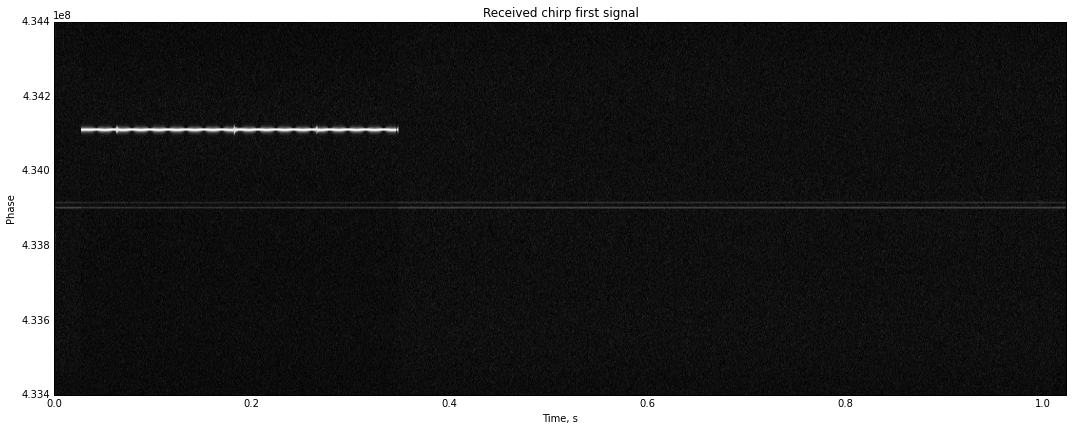

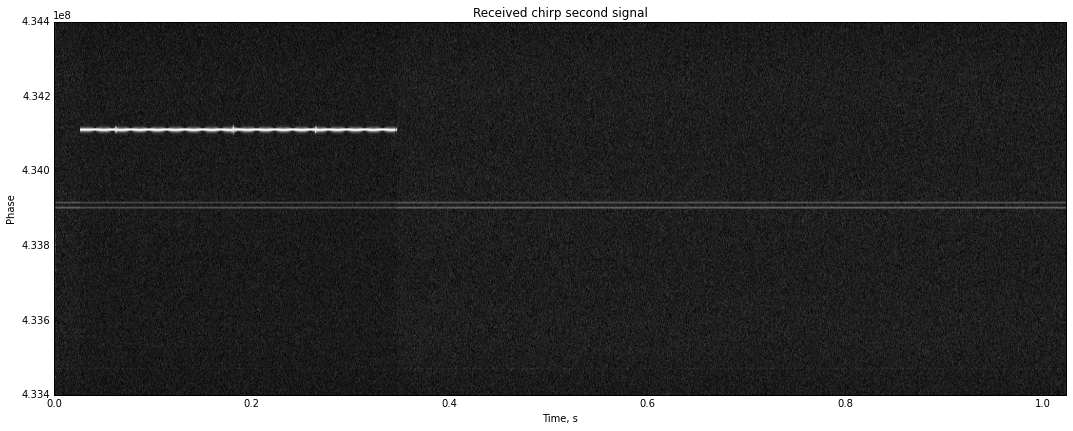

In [133]:
m = 512
fs = 1e6 #1e6 #3.2e6 #240000
fc = 433.9e6 #145.230e6 #145.530e6 #315e6 #144.25e6 #443.61e6

myspectrogram_hann_ovlp(y0, m, fs, fc, dbf = 60)
plt.title('Received chirp first signal')
myspectrogram_hann_ovlp(y1, m, fs, fc, dbf = 60)
plt.title('Received chirp second signal')

In [ ]:
taps = 685
# taps = 700

mod_val = -0.016e6 #0.04e6 #-0.3e6
h = sp.signal.firwin(taps, 1/fs)
t = np.arange(taps) * (1/fs)
mod = exp(-1j*2*pi*mod_val*t)
h = h*mod

filt_y0 = signal.fftconvolve(y0, h)
filt_y1 = signal.fftconvolve(y1, h)

myspectrogram_hann_ovlp(filt_y0, m, fs, fc,dbf = 63)
title('dongle 0 filtered')
myspectrogram_hann_ovlp(filt_y1, m, fs, fc,dbf = 63)
title('dongle 1 filtered')

freq0 = np.fft.fftshift(np.fft.fft(filt_y0)) 
freq1 = np.fft.fftshift(np.fft.fft(filt_y1)) 
figure()
plt.plot(abs(freq0))
figure()
plt.plot(abs(freq1))

print abs(freq0).tolist().index(max(abs(freq0)))
print abs(freq1).tolist().index(max(abs(freq1)))
print (abs(freq0)-abs(freq1)).tolist().index(max(abs(freq0)-abs(freq1)))

figure()
plt.plot((abs(freq0)-abs(freq1))) #[225000:275000]
